# Fuzzy Logic for Python 3

The doctests in the modules should give a good idea how to use things by themselves, while here are some examples how to use everything together.

### Functions and Sets
Defining a domain with its range and resolution should be trivial since most real world instruments come with those specifications. However, defining the fuzzy sets within those domains is where the fun begins as only a human can tell whether something is "hot" or "not", right?

Why the distinction? Functions only map values, nothing special there at all - which is good for testing and performance. Sets on the other hand implement logical operations that have special python syntax, which makes it easy to work with but a little more difficult to test and adds some performance overhead. So, sets are for abstraction and easy handling, functions for performance.

### Domains
You can use (I do so regularly) fuzzy functions outside any specific fuzzy context. However, if you want take advantage of the logic of fuzzy sets, plot stuff or defuzzyfy values, you need to use Domains. Domains and Sets are special in a way that they intrically rely on each other. This is enforced by how assignments work. Regular Domain attributes are the sets that were assigned to the domain. Also, if just a function is assigned it is automatically wrapped in a Set.

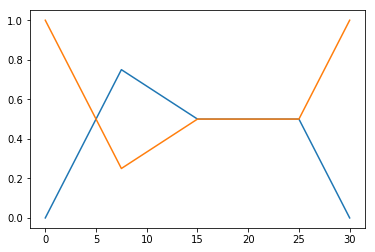

In [9]:
%matplotlib inline
from fuzzy.classes import Domain
from fuzzy.functions import R, S, alpha

T = Domain("test", 0, 30, res=0.1)

T.up = R(0,10)
T.top = alpha(floor=0.5, ceiling=1, func=S(0, 30))
T.down = S(20, 30)
T.polygon = up & top & down

T.polygon.plot()
T.not_polygon = ~T.polygon
T.not_polygon.plot()

let's show off a few interesting functions ;)

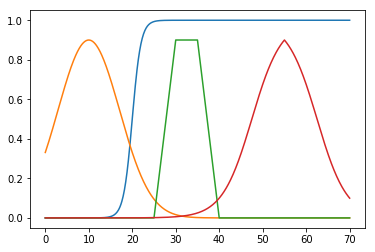

In [2]:
%matplotlib inline
from fuzzy.classes import Domain, Set
from fuzzy.functions import (sigmoid, gauss, trapezoid, 
                             triangular_sigmoid, rectangular)

T = Domain("test", 0, 70, res=0.1)
T.sigmoid = sigmoid(1,1,20)
T.sigmoid.plot()
T.gauss = gauss(10, 0.01, c_m=0.9)
T.gauss.plot()
T.trapezoid = trapezoid(25, 30, 35, 40, c_m=0.9)
T.trapezoid.plot()
T.triangular_sigmoid = triangular_sigmoid(40, 70, c=55)
T.triangular_sigmoid.plot()

you can do more than that :)

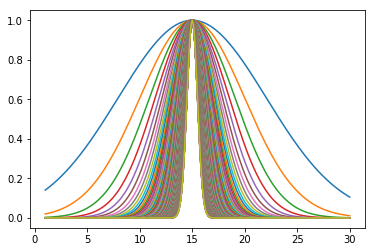

In [3]:
from fuzzy.classes import Set, Domain
from fuzzy.functions import gauss
from numpy import arange

d = Domain("d", 1, 30, res=0.1)
for c, x in enumerate(arange(0.01,2, 0.01)):
    s = Set(gauss(15, x), name=f"_{c}", domain=d)
    s.plot()

### Domains

After specifying the domain and assigning sets, calling a domain with a value returns a dict of memberships of the sets in that domain.

{'foo': 0.5443310539518174,
 'bar': 0.6400000000000001,
 'baz': 0.8359591794226543}

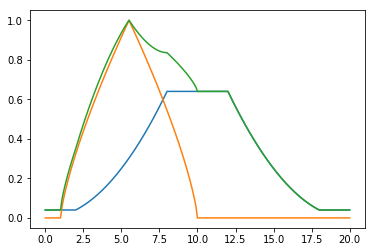

In [4]:
%matplotlib inline

from fuzzy.classes import Domain
from fuzzy.functions import alpha, triangular
from fuzzy.hedges import plus, minus, very

numbers = Domain("numbers", 0, 20, res=0.1)

close_to_10 = alpha(floor=0.2, ceiling=0.8, func=triangular(0, 20))
close_to_5 = triangular(1, 10)

numbers.foo = minus(close_to_5)
numbers.bar = very(close_to_10)

numbers.bar.plot()
numbers.foo.plot()
numbers.baz = numbers.foo + numbers.bar
numbers.baz.plot()

numbers(8)

{'cold': 0.5, 'hot': 0.012195121951219511, 'warm': 0.5}

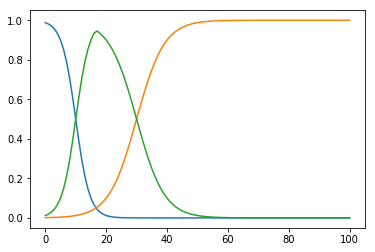

In [5]:
from fuzzy.classes import Domain
from fuzzy.functions import bounded_sigmoid

T = Domain("temperature", 0, 100)
T.cold = bounded_sigmoid(5,15, inverse=True)
T.cold.plot()
T.hot = bounded_sigmoid(20, 40)
T.hot.plot()
T.warm = ~T.hot & ~T.cold
T.warm.plot()
T(10)

Many times you end up with sets that never hit 1 like with sigmoids, triangular funcs that hit the border of the domain or after operations with other sets. Then it is often needed to normalize (define max(set) == 1). Note that Set.normalized() returns a set that (unlike other set ops) is already bound to the domain and given the name "normalized\_{set.name}". This can't be circumvented because normalizing is only defined on a given domain.

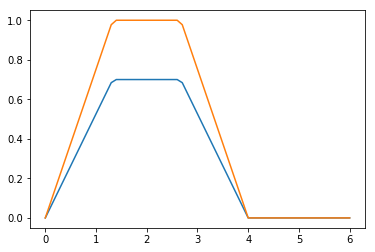

In [6]:
%matplotlib inline

from fuzzy.classes import Domain
from fuzzy.functions import alpha, trapezoid

N = Domain("numbers", 0, 6, res=0.1)
N.two_or_so = alpha(floor=0, ceiling=0.7, func=trapezoid(0, 1.9, 2.1, 4))
N.two_or_so.plot()
N.x = N.two_or_so.normalized()
N.x.plot()

### Inference

After measuring a RL value and mapping it to sets within a domain, it is normally needed to translate the result to another domain that corresponds to some sort of control mechanism. This translation or mapping is called inference and is rooted in the logical conclusion operation A => B, for example: If it rains then the street is wet.
The street may be wet for a number of reasons, but if it rains it will be wet for sure. This **IF A THEN B** can also be written as
***(A AND B) OR NOT(A AND TRUE)***. This may look straight forward for boolean logic, but since we are not just dealing with True and False, there are a number of ways in fuzzy logic to actually implement this.

Oftentimes "real" logical conclusion isn't actually what you need, instead you might want to build something like a weighted decision tree, which is very easy to do.
Let's see how to rate a meal as an example.
Just keep in mind that rule functions take a dict of membership values as single argument once parametrized. So, in this case, the ratings dict either needs to be sanitized before passed into the rule or constructed from the beginning (which I've done here) in the appropriate way.

In [10]:
from fuzzy.classes import Domain
from fuzzy.functions import R, S

t = Domain("test", 0, 10)
t.low = S(0,7)
t.high = R(4,15)

t.high_ = t.high.normalized() & t.low

In [11]:
from fuzzy.classes import Domain
from fuzzy.functions import bounded_linear
from fuzzy.rules import weighted_sum

rating = Domain("rating", 1, 10, res=0.1)
rating.norm = bounded_linear(1, 10)
weights = {"beverage": 0.3, 
            "atmosphere": 0.2, 
            "looks":0.2,
            "taste": 0.3}

w_func = weighted_sum(weights=weights, target_d=rating)      

# we've rated beverage etc. on a scale from 1 to 10 separately
ratings = {"beverage": rating.min(9),
            "atmosphere": rating.min(5),
            "looks": rating.min(4),
            "taste": rating.min(8)}

w_func(ratings)

6.9

## Sources
* Fuzzy Logic and Control: Software and Hardware Applications, Volume 2

      By: Mohammad Jamshidi; Nader Vadiee; Timothy J. Ross - University of New Mexico
      Publisher: Prentice Hall
      Pub. Date: June 07, 1993
      
* Computational Intelligence - Fuzzy-Tutorial
      
      Prof. Dr. habil. A. Grauel
      
* http://petro.tanrei.ca/fuzzylogic/fuzzy_negnevistky.html
* http://kik.informatik.fh-dortmund.de/abschlussarbeiten/fuzzyControl/operatoren.html